In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import tensorflow as tf

# Shot Boundaries 

In [3]:
def detect_shot_boundaries(video_path, threshold=10):

    videoStruct = {}
    cap = cv2.VideoCapture(video_path)

    prev_frame = None
    frame_diffs = [0]
    # frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if prev_frame is not None:
            diff = cv2.absdiff(gray, prev_frame)
            frame_diffs.append(diff.mean())
            # frames.append(frame)

        prev_frame = gray

    avg_diff = sum(frame_diffs) / len(frame_diffs)

    # shot_boundaries = []
    counter = 1
    for i, diff in enumerate(frame_diffs):
        if diff > threshold * avg_diff:
            # videoStruct[str(counter)] = np.asarray([[i], frames[i]])
            # plt.imshow(frames[i])
            # plt.show()
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            videoStruct[str(counter)] = (i,frame)
            counter += 1

    # cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    # current_shot = 0
    # while cap.isOpened():
    #     ret, frame = cap.read()
    #     if not ret:
    #         break

    #     if current_shot < len(shot_boundaries) and \
    #             shot_boundaries[current_shot] == cap.get(cv2.CAP_PROP_POS_FRAMES):
    #         cv2.line(frame, (0, 0), (0, frame.shape[0]), (0, 0, 255), thickness=3)
    #         current_shot += 1

    #     cv2.imshow('Video with shot boundaries', frame)
    #     if cv2.waitKey(25) & 0xFF == ord('q'):
    #         break
    # cap.release()
    cv2.destroyAllWindows()

    return videoStruct

In [26]:
# vidPath = './project/episodes/BBTS1E1.mp4'
vidPath = './project/episodes/BBTS1E3.mp4'
# vidPath = './project/data/BBT_S1_E1.mp4'

shot_boundaries = detect_shot_boundaries(vidPath)
print(shot_boundaries)

{'1': (166, array([[[11,  1,  1],
        [11,  1,  1],
        [12,  2,  2],
        ...,
        [ 1,  0,  4],
        [ 1,  0,  4],
        [ 1,  0,  4]],

       [[ 9,  0,  0],
        [ 9,  0,  0],
        [10,  0,  0],
        ...,
        [ 1,  0,  4],
        [ 1,  0,  4],
        [ 1,  0,  4]],

       [[16,  6,  6],
        [16,  6,  6],
        [17,  7,  7],
        ...,
        [ 1,  0,  4],
        [ 1,  0,  4],
        [ 1,  0,  4]],

       ...,

       [[ 8,  3, 15],
        [ 8,  3, 15],
        [ 8,  3, 15],
        ...,
        [ 8,  0,  5],
        [ 8,  0,  5],
        [ 8,  0,  5]],

       [[ 8,  3, 15],
        [ 8,  3, 15],
        [ 8,  3, 15],
        ...,
        [11,  0,  2],
        [11,  0,  2],
        [11,  0,  2]],

       [[ 8,  3, 15],
        [ 8,  3, 15],
        [ 8,  3, 15],
        ...,
        [11,  0,  2],
        [11,  0,  2],
        [11,  0,  2]]], dtype=uint8)), '2': (334, array([[[33, 43, 53],
        [33, 43, 53],
        [32, 42, 52],
 

# Shot Threading 

In [28]:
def thread_shots_with_sift_matching(shot_boundaries, threshold=0.5, num_frames_per_thread=25):
    sift = cv2.SIFT_create()
    threads = []
    done_thread = np.zeros(len(shot_boundaries))

    # cap = cv2.VideoCapture(video_path)
    for i in range(len(shot_boundaries) - 1):
        if done_thread[i] == 1:
            continue
        # cap.set(cv2.CAP_PROP_POS_FRAMES, shot_boundaries[i])
        # ret, last_frame = cap.read()
        last_frame = shot_boundaries[str(i+1)][1]
        last_frame_features = sift.detectAndCompute(last_frame, None)[1]

        if last_frame_features is None:
            continue

        present_thread = [i]
        # present_thread = []
        thread_scores = {i: 0}
        

        for j in range(i + 1, min(i + num_frames_per_thread, len(shot_boundaries))):
            if done_thread[j] == 1:
                continue
            # cap.set(cv2.CAP_PROP_POS_FRAMES, shot_boundaries[j] + 1)
            # ret, next_frame = cap.read()
            next_frame = shot_boundaries[str(j+1)][1]
            next_frame_features = sift.detectAndCompute(next_frame, None)[1]

            if next_frame_features is None:
                continue
            
            print(i,j)

            bf = cv2.BFMatcher()
            matches = bf.knnMatch(last_frame_features, next_frame_features, k=2)

            good = []
            for m, n in matches:
                if m.distance < threshold * n.distance:
                    good.append([m])

            score = len(good)
            thread_scores[j] = score

            if score > threshold * num_frames_per_thread:
                present_thread.append(j)
                done_thread[j] = 1
                # last_frame_features = next_frame_features

        threads.append(present_thread)
        done_thread[i] = 1

    # cap.release()

    return threads

In [ ]:
threads = thread_shots_with_sift_matching(shot_boundaries)

In [30]:
def make_adjacency_matrix(threads, numShots):
    
    adj_mat = np.zeros((numShots, numShots))
    for thread in threads:
        for i in range(len(thread) - 1):
            for j in range(i + 1, len(thread)):
             adj_mat[thread[i]][thread[j]] = 1
             adj_mat[thread[j]][thread[i]] = 1
    return adj_mat

numShots = len(shot_boundaries)
adj_mat = make_adjacency_matrix(threads, numShots)
print(adj_mat)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [31]:
print(adj_mat.shape)

(461, 461)


# Shot Representation 

In [32]:
def shot_histogram(shot, visualize = True):
    # shot_hist = np.zeros((6, 6, 6), dtype=np.float32)
    bin_size = 42
    num_bins = 256 // bin_size

    pixels = shot.reshape(-1, 3)

    # r_bins = pixels[:, 0] // bin_size
    # g_bins = pixels[:, 1] // bin_size
    # b_bins = pixels[:, 2] // bin_size

    shot_hist = np.zeros((6, 6, 6), dtype=np.float32)
    r_bins = pixels[:, 0] // bin_size
    g_bins = pixels[:, 1] // bin_size
    b_bins = pixels[:, 2] // bin_size

    r_indices = r_bins - 1
    g_indices = g_bins - 1
    b_indices = b_bins - 1

    mask = (r_indices >= 0) & (r_indices < num_bins) & (g_indices >= 0) & (g_indices < num_bins) & (b_indices >= 0) & (b_indices < num_bins)
    # print(mask)

    # Use the mask and the indices to update the histogram array
    np.add.at(shot_hist, (r_indices[mask], g_indices[mask], b_indices[mask]), 1)

        

    if visualize:
        plt.figure(figsize=(10, 10))
        # plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(shot, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        # plt.subplot(1, 2, 2)
        x, y, z = np.indices(shot_hist.shape)
        x = x.flatten()
        y = y.flatten()
        z = z.flatten()
        colors = np.array([shot_hist[x[i], y[i], z[i]] for i in range(len(x))])
        # Create a 3D scatter plot of the data
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, c=colors,s=10,  marker='o')
        ax.set_xlabel('Red bins')
        ax.set_ylabel('Green bins')
        ax.set_zlabel('Blue bins')
        plt.show()

    return shot_hist

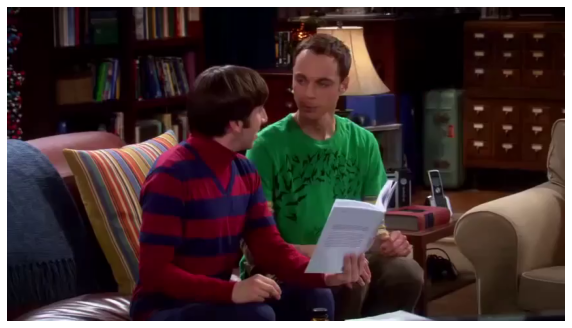

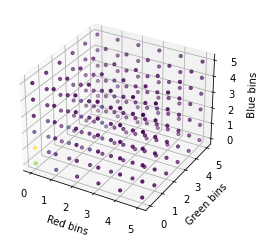

In [33]:
x = shot_histogram(shot_boundaries['5'][1])

In [34]:
def shot_dist_set(shot, P, shot_boundaries):
    numShots = len(P)
    dist = 0
    shotHist = shot_histogram(shot_boundaries[str(shot+1)][1], visualize=False)
    for i in range(numShots):
        tempHist = shot_histogram(shot_boundaries[str(P[i]+1)][1], visualize=False)
        dist += cv2.compareHist(shotHist, tempHist, cv2.HISTCMP_BHATTACHARYYA)
    return dist / numShots  

In [36]:
print(shot_dist_set(4, threads[0], shot_boundaries))
print(shot_dist_set(0, threads[24], shot_boundaries))

0.11730104227446238
0.7995434756765227


# Scene Detection 

In [37]:
def thread_score(shot, P, adj_mat):
    # print(len(P))
    score = 0
    for i in range(len(P)):
        if adj_mat[shot][P[i]] == 1:
            return 1
            # score += 1
    return 0

In [38]:
def alphas(k, Nl):
 return 1-((k/Nl)**2)*0.5

In [39]:
def dynamic_score(shot_boundaries, shot, P, adj_mat, Nl = 35):
    score = alphas(shot, Nl)*(thread_score(shot, P, adj_mat) + shot_dist_set(shot, P, shot_boundaries))
    return score

In [40]:
def scene_detection(Nsc, Nl, shot_boundaries, adj_mat):
    Nsh = len(shot_boundaries)
    D = np.zeros((Nsc, Nsh, Nl))

    for i in range(Nsc):
        for j in range(1, Nsh):
            for k in range(1, Nl):
                P = np.arange(j-k+1, k)
                D[i, j, k] = D[i, j-1, k-1] + alphas(k, Nl) * (shot_dist_set(j, P, shot_boundaries) + thread_score(j, P, adj_mat))

    for i in range(Nsc):
        for j in range(1, Nsh):
            D[i, j, 0] = max(D[i, j-1, k] + (1-alphas(k, Nl))(1-shot_dist_set(k, P, shot_boundaries)+(1 - thread_score(k, P, adj_mat))) for k in range(1, Nl))

    scene_boundaries = []
    for i in range(Nsc):
        scene_boundaries.append(np.argmax(D[i, Nsh-1, :]))

    return scene_boundaries


In [41]:
def scene_detection(Nsc, Nl, shot_boundaries, adj_mat):
    # prev_score = 0
    k_optimal = -1
    scene_boundaries = []
    
    # if(Nsc == 1):
    #     return scene_boundaries
    # if(len(shot_boundaries)==1):
    #     return scene_boundaries
    
    prevk = 0
    while(Nsc > 1):
        D = np.zeros(Nl)
        for i in range(1, Nl):
            P = np.arange(prevk, i+prevk)
            D[i] = dynamic_score(shot_boundaries, i+prevk, P, adj_mat)
        Nsc -= 1
        k_optimal = np.argmax(D)+prevk+1
        scene_boundaries.append(k_optimal)
        prevk = k_optimal
    scene_boundaries.append(len(shot_boundaries))
    return scene_boundaries

# Face Recognition

In [54]:
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./images"))

# Any results you write to the current directory are saved as output.

['howard', 'leonard', 'penny', 'raj', 'sheldon']


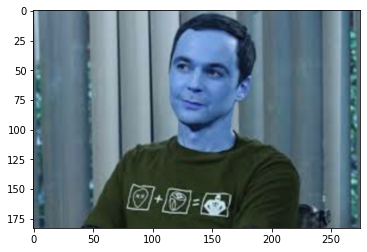

(183, 275, 3)


In [56]:
img = cv2.imread('./images/sheldon/1.jpeg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(img.shape)

In [57]:
# extract a single face from a given photograph
def extract_face(image, required_size=(160, 160)):
    # load image from file
    # image = Image.open(filename)
    # convert to RGB, if needed
    # image = image.convert('RGB')
    
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # if no faces are detected then return None
    if len(results) == 0:
        return None
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array


In [58]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [59]:
data = np.load('dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (19, 160, 160, 3) (19,) (4, 160, 160, 3) (4,)


In [60]:
from keras_facenet import FaceNet

In [61]:
facenet_model = FaceNet()
print('Loaded Model')

Loaded Model


In [62]:
def get_embedding(model, face):
    # scale pixel values
    # face = face.astype('float32')
    # standardization
    # mean, std = face.mean(), face.std()
    # face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.embeddings(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('embeddings.npz', emdTrainX, trainy, emdTestX, testy)

1/1 [==============================] - 0s 48ms/step
(19, 512)
1/1 [==============================] - 0s 51ms/step
(4, 512)


In [64]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=19, test=4
Accuracy: train=100.000, test=100.000


In [65]:
charecters = []

for i in range(len(shot_boundaries)):
    image = shot_boundaries[str(i+1)][1]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pixels = extract_face(image)
    if pixels is None:
        charecters.append('None')
        continue
    embedding = get_embedding(facenet_model, pixels)
    embedding_norm = in_encoder.transform(np.expand_dims(embedding, axis=0))
    yhat_class = model.predict(embedding_norm)
    charecters.append(out_encoder.inverse_transform(yhat_class)[0])


1/1 [==============================] - 0s 79ms/step


In [66]:
len(charecters)

461

In [67]:
charecters

['leonard',
 'penny',
 'sheldon',
 'penny',
 'sheldon',
 'penny',
 'sheldon',
 'sheldon',
 'penny',
 'sheldon',
 'penny',
 'sheldon',
 'leonard',
 'sheldon',
 'leonard',
 'None',
 'leonard',
 'None',
 'leonard',
 'None',
 'penny',
 'None',
 'leonard',
 'None',
 'leonard',
 'sheldon',
 'penny',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'leonard',
 'penny',
 'None',
 'None',
 'None',
 'None',
 'leonard',
 'None',
 'None',
 'leonard',
 'None',
 'penny',
 'sheldon',
 'None',
 'None',
 'leonard',
 'None',
 'leonard',
 'leonard',
 'leonard',
 'None',
 'None',
 'leonard',
 'leonard',
 'sheldon',
 'None',
 'penny',
 'None',
 'penny',
 'None',
 'None',
 'penny',
 'penny',
 'leonard',
 'None',
 'None',
 'None',
 'penny',
 'penny',
 'leonard',
 

# Loss Functions

In [68]:
# scene_boundaries = [3, 18, 36, 37, 45, 75, 98, 105, 118, 127, 203, 220, 251, 268, 290, 298, 328, 329, 338, 351, 364, 366, 411]
scene_boundaries = [2, 45, 61, 97, 98, 104, 108, 135, 138, 180, 199, 211, 240, 241, 270, 277, 293, 294, 347, 370, 373, 375, 411]

In [69]:
chars = ['howard', 'leonard', 'penny', 'raj','sheldon']
Nsc = len(scene_boundaries)
Nt = Nsc
muS = 0.3

In [70]:
def cooccurance(c1, c2, scene1, scene2, charecters):
    count1 = 0
    count2 = 0
    for i in range(scene1, scene2):
        if charecters[i] == c1:
            count1 += 1
        elif charecters[i] == c2:
            count2 += 1
    # geometric mean of count1 and 2
    return np.sqrt(count1*count2)

In [71]:
def proximity(Np, Nt, chars, scene_boundaries, charecters, x):
    Nc = len(chars)
    sum = 0
    scene1 = 0
    for t in range(Nt):
        scene2 = scene_boundaries[t]
        xNow = x[t][:]
        for i in range(Nc):
            for j in range(i+1, Nc):
                char1 = chars[i]
                char2 = chars[j]
                cooccur = cooccurance(char1, char2, scene1, scene2, charecters)
                sum += cooccur*((xNow[i]-xNow[j])**2)
        scene1 = scene2
    L1 = sum/(Np*Nt)

    sum = 0
    scene1 = 0
    for t in range(Nt):
        scene2 = scene_boundaries[t]
        xNow = x[t][:]
        for i in range(Nc):
            for j in range(i+1, Nc):
                char1 = chars[i]
                char2 = chars[j]
                cooccur = cooccurance(char1, char2, scene1, scene2, charecters)
                sum += (cooccur==0)*((xNow[i]-xNow[j])**2)
        scene1 = scene2

    L2 = sum/(Np*Nt)
    return L1-L2


In [72]:
def straightLines(Nc, Nt, mu, x):
    sum = 0
    for t in range(Nt):
        xNow = x[t][:]
        mu = (x.sum(axis=0)-x[t][:])/(Nt-1)
        for i in range(Nc):
            sum += (xNow[i]-mu[i])**2
    return sum/(Nc*Nt)

In [73]:
def z(x, mu):
    resZ = 0
    if x<mu:
        resZ = (1/x)*(np.sqrt(1+(x-mu)**2)-1)
    return resZ

def minSeparation(Np, Nt, muS, x):
    Ls = 0
    for t in range(Nt):
        xNow = x[t][:]
        for i in range(len(xNow)):
            for j in range(i+1, len(xNow)):
                Ls += z((xNow[i]-xNow[j])**2, muS)
    return Ls/(Np*Nt)

In [74]:
def H(x, mu):
    res = 0
    if x<mu:
        res = np.sqrt(1+(x-mu)**2)-1
    return res

def crossings(Np, Nt, x, muC=0):
    Lc = 0
    for t in range(Nt):
        xNow = x[t][:]
        for i in range(len(xNow)-1):
            for j in range(i+1, len(xNow)-1):
                Lc += H((xNow[i]-xNow[j])*(xNow[i+1]-xNow[j+1]), muC)
    return Lc/(Np*Nt)

In [75]:
def objectiveFun(x):
    Nc = len(chars)
    Np = Nc*(Nc-1)/2

    x = np.reshape(x, (Nt, Nc))

    return proximity(Np, Nt, chars, scene_boundaries, charecters, x) + minSeparation(Np, Nt, muS, x) + straightLines(Nc, Nt, muS, x) + crossings(Np, Nt, x)

In [76]:
from scipy.optimize import minimize
from scipy.interpolate import interp1d, CubicSpline

In [77]:
# x0 = np.array([1,2,3,1,2,3,1,2,3])
x0 = []
bounds = [(1, len(chars))]*len(chars)*Nt
for i in range(len(scene_boundaries)):
    x0 = x0 + [1.2,2.3,2.6,2.7,1.3]
# print(x0)
res = minimize(objectiveFun, x0, bounds=bounds, method='nelder-mead', options={'disp': True})
coords = res.x
coords = np.reshape(coords, (Nt, len(chars)))
coords = coords.T
coords

C:\Users\sreen\AppData\Local\Temp\ipykernel_43224\3365606470.py:7: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(objectiveFun, x0, bounds=bounds, method='nelder-mead', options={'disp': True})


array([[1.34961704, 1.27216824, 1.39343857, 1.21349061, 1.20149136,
        1.02821   , 1.04994055, 1.29025373, 1.26666205, 1.13082745,
        1.38663879, 1.12531157, 1.00246836, 1.14370657, 1.2318914 ,
        1.05391825, 2.12048637, 1.26011146, 1.20565156, 1.29254275,
        1.04479075, 1.06777951, 1.30245388],
       [1.83730777, 1.64144882, 4.09521599, 2.01487561, 1.73771382,
        1.36858223, 1.41536866, 1.82900085, 3.52209313, 1.89422147,
        1.63125693, 1.72445141, 1.33676548, 1.43052746, 1.94787392,
        1.49482044, 2.5578532 , 3.08357982, 1.89221012, 1.58172425,
        1.51653425, 1.83104074, 2.68877815],
       [2.95958277, 1.93972302, 4.79874508, 2.86158083, 3.07230938,
        1.53716489, 1.61197883, 2.07313915, 3.80016342, 2.08595412,
        1.7900244 , 1.99499409, 1.66517435, 1.70875767, 2.17790159,
        2.84901334, 2.83294701, 3.24245601, 2.07906479, 1.81141657,
        1.72583133, 2.10280274, 2.8553945 ],
       [4.97366315, 4.83254542, 4.98810993, 3.194

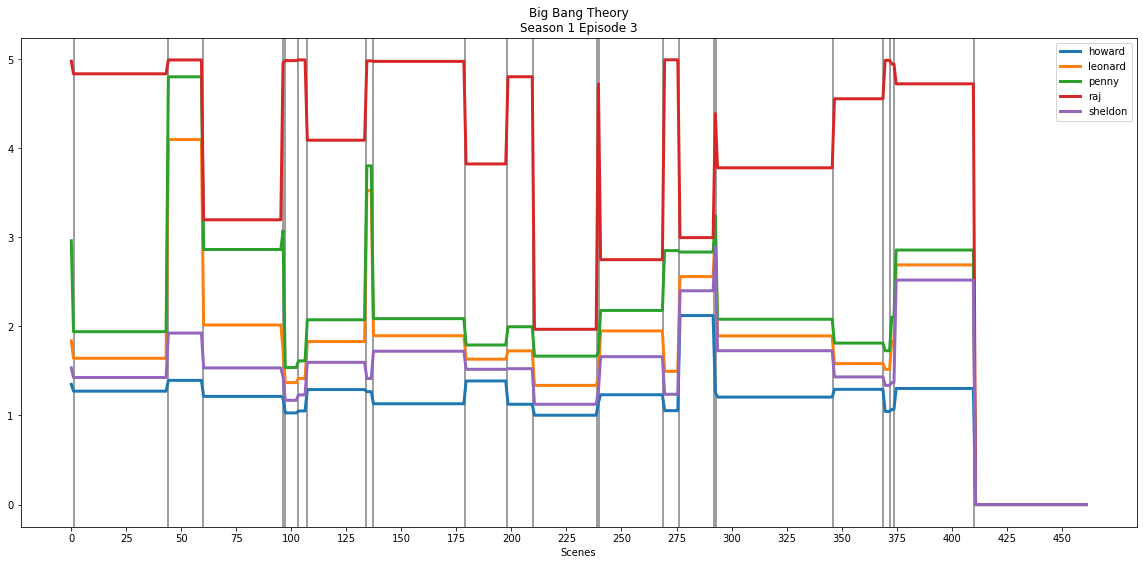

In [78]:
# plot the results
import matplotlib.pyplot as plt

# linspace for x axis from 0 to len(shot_boundaries)
x_axis = np.linspace(0, len(shot_boundaries), len(shot_boundaries))

y_axis = np.zeros((len(chars), len(shot_boundaries)))

temp = 0
for i in range(len(scene_boundaries)):
    temp2 = scene_boundaries[i]-1
    y_axis[:, temp:temp2] = np.stack((coords[:, i],)*(temp2-temp), axis=1)
    temp = temp2

x_final = np.linspace(0, len(shot_boundaries), len(shot_boundaries)*10)
y_final = np.zeros((len(chars), len(shot_boundaries)*10))
for i in range(len(chars)):
    y_temp = y_axis[i][:]
    f = interp1d(x_axis, y_temp, kind='cubic')
    # f = CubicSpline(x_axis, y_temp)
    y_final[i][:] = f(x_final)


plt.figure(figsize=(20,9))
for i in range(len(scene_boundaries)):
    plt.axvline(x=scene_boundaries[i]-1, color='grey')
for i in range(len(chars)):
    plt.plot(x_axis , y_axis[i],label=chars[i], linewidth=3) 
# plt.grid()
plt.xlabel('Scenes')
plt.xticks(np.arange(0, len(shot_boundaries), 25))
plt.title('Big Bang Theory\nSeason 1 Episode 3')
plt.legend()
plt.show()


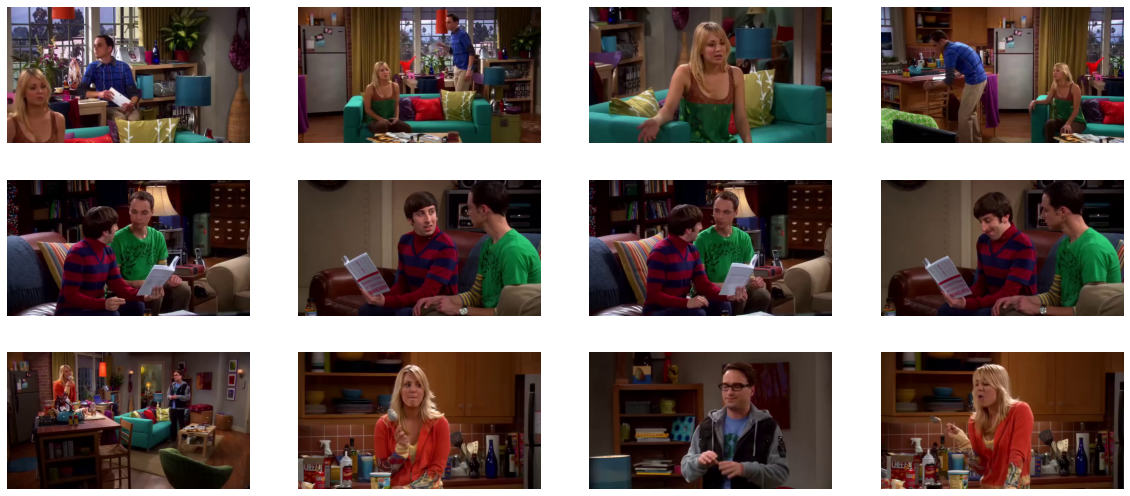

In [79]:
s = [scene_boundaries[-4], scene_boundaries[0], scene_boundaries[-10]]

plt.figure(figsize=(20,9))
x = 1
for i in range(len(s)):
    for j in range(4):
        plt.subplot(3, 4, x)
        plt.imshow(cv2.cvtColor(shot_boundaries[str(s[i]+j+1)][1], cv2.COLOR_BGR2RGB))
        plt.axis('off')
        x += 1
plt.show()


# Quality

In [81]:
def move(coords, Nc):
    moved = 0
    for i in range(Nc):
        temp = coords[i][:]
        moved += np.max(temp)-np.min(temp)
    return moved/Nc

def maxSep(coords, Nt):
    sep = 0
    for i in range(Nt):
        temp = coords[:, i]
        max = 0
        for j in range(len(temp)-1):
            for k in range(j+1, len(temp)):
                if abs(temp[j]-temp[k])>max:
                    max = abs(temp[j]-temp[k])
        sep += max
    return sep/Nt

In [82]:
def crossingsRes(coords):
    Nc = len(coords)
    Nt = len(coords[0])
    score = 0

    for i in range(Nt-1):
        for j in range(Nc-1):
            for k in range(j+1, Nc):
                if (coords[j][i]-coords[k][i])*(coords[j][i+1]-coords[k][i+1])<0:
                    score += 1
    return score

In [83]:
moved = move(coords, len(chars))
sep = maxSep(coords, Nt)
crosses = crossingsRes(coords)

print('-------------------------------------------------------------------------')
print('        Big Bang Theory Season 1 Episode 3')
print('-------------------------------------------------------------------------')
print('Move\t\t\t|\tSeparation\t\t|      Crossings')
print('-------------------------------------------------------------------------')
print(str(moved)+'\t|\t'+str(sep)+'\t|\t'+str(crosses))
print('-------------------------------------------------------------------------')

-------------------------------------------------------------------------
        Big Bang Theory Season 1 Episode 3
-------------------------------------------------------------------------
Move			|	Separation		|      Crossings
-------------------------------------------------------------------------
2.3864683381940166	|	3.1268951918846666	|	0
-------------------------------------------------------------------------
